In [1]:
#Dataset Description
#date - The calendar date of the observation (YYYY-MM-DD)
#hour - The hour of the day (0-23) when the measurement was recorded
#dry_bulb - Dry bulb temperature in °C (regular air temperature)
#dew_pnt - Dew point temperature in °C (temperature at which air becomes saturated)
#working_day - Flag indicating if the day is a working day (0 = working day, 1 = weekend/holiday)
#day_of_week - Day of the week as a number (Monday=0, Sunday=6)
#sys_load - System load or demand at the given date and hour (Target variable for our predictive models)

In [2]:
#Import required libraries
import pandas as pd
import numpy as np
import datetime as dt
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# Loading data & showing all train and valid data
data=pd.read_excel('train&valid_data.xlsx')
print(data)

            Date  Hour  DryBulb  DewPnt  SYSLoad   NumDate
0     2004-01-01   1.0     37.0    25.0  12230.0  732000.0
1     2004-01-01   2.0     37.0    25.0  11534.0  732000.0
2     2004-01-01   3.0     39.0    24.0  11038.0  732000.0
3     2004-01-01   4.0     38.0    22.0  10777.0  732000.0
4     2004-01-01   5.0     37.0    20.0  10764.0  732000.0
...          ...   ...      ...     ...      ...       ...
52603        NaT   NaN      NaN     NaN      NaN       NaN
52604        NaT   NaN      NaN     NaN      NaN       NaN
52605        NaT   NaN      NaN     NaN      NaN       NaN
52606        NaT   NaN      NaN     NaN      NaN       NaN
52607 2009-12-31  24.0     27.0    24.0  13953.0  734000.0

[52608 rows x 6 columns]


In [4]:
#Reading holidays excel
hdata = pd.read_excel('Holidays_list.xls')
holidays = pd.to_datetime(hdata['Date'])
print(holidays.head())

0   2004-01-01
1   2004-01-19
2   2004-02-16
3   2004-05-31
4   2004-07-05
Name: Date, dtype: datetime64[ns]


In [5]:
#STEP1: DATA PREPARATION AND CLEANING FOR TRAIN AND VALID DATA FILE
# Create a new column working_day
data['Date'] = pd.to_datetime(data['Date'])
isworkday = np.isin(data.Date.dt.weekday, [0, 1, 2, 3, 4]) & ~np.isin(data['Date'], holidays)
data['working_day'] = np.where(isworkday,0,1)
# Create a new column day_of_week (Monday=0, Sunday=6)
data['day_of_week'] = data['Date'].dt.weekday.astype('Int64')
print("First 5 rows of data with 'Date' and 'working_day' columns:")
display(data.head())

First 5 rows of data with 'Date' and 'working_day' columns:


,Date,Hour,DryBulb,DewPnt,SYSLoad,NumDate,working_day,day_of_week
0,2004-01-01,1.0,37.0,25.0,12230.0,732000.0,1,3
1,2004-01-01,2.0,37.0,25.0,11534.0,732000.0,1,3
2,2004-01-01,3.0,39.0,24.0,11038.0,732000.0,1,3
3,2004-01-01,4.0,38.0,22.0,10777.0,732000.0,1,3
4,2004-01-01,5.0,37.0,20.0,10764.0,732000.0,1,3


In [6]:
#Display dimensions of data frame
data.shape

(52608, 8)

In [7]:
# Checking for data types
data.dtypes


Date           datetime64[ns]
Hour                  float64
DryBulb               float64
DewPnt                float64
SYSLoad               float64
NumDate               float64
working_day             int64
day_of_week             Int64
dtype: object

In [8]:
#Changing all column names to lowercase
data.columns = data.columns.str.lower()

#rename column names
data.rename(columns={'drybulb': 'dry_bulb', 'dewpnt': 'dew_pnt', 'numdate': 'num_date', 'sysload':'sys_load'}, inplace=True)

print("Column names after changes:")
print(data.columns)

Column names after changes:
Index(['date', 'hour', 'dry_bulb', 'dew_pnt', 'sys_load', 'num_date',
       'working_day', 'day_of_week'],
      dtype='object')


In [9]:
#Drop num_date column since we already have date column
data.drop('num_date', axis=1, inplace=True)
print("Columns after dropping 'num_date':")
print(data.columns)

Columns after dropping 'num_date':
Index(['date', 'hour', 'dry_bulb', 'dew_pnt', 'sys_load', 'working_day',
       'day_of_week'],
      dtype='object')


In [10]:
# Checking for duplicate rows
print("\nDuplicate rows found:")
data.duplicated().sum()




Duplicate rows found:


np.int64(26302)

In [11]:
#Remove duplicate records
data.drop_duplicates(inplace=True)
print("\nRows after duplicates removed:")
data.shape


Rows after duplicates removed:


(26306, 7)

In [12]:
# Checking for missing values in each column
data.isnull().sum()

date           1
hour           1
dry_bulb       1
dew_pnt        1
sys_load       1
working_day    0
day_of_week    1
dtype: int64

In [13]:
#Remove missing values
data.dropna(inplace=True)
print("\nMissing values removed:")
data.isnull().sum()


Missing values removed:


date           0
hour           0
dry_bulb       0
dew_pnt        0
sys_load       0
working_day    0
day_of_week    0
dtype: int64

In [14]:
#Summary statistics to check if data is within valid and acceptable range
data.describe()

,date,hour,dry_bulb,dew_pnt,sys_load,working_day,day_of_week
count,26305,26305.000000,26305.000000,26305.000000,26305.000000,26305.00000,26305.0
mean,2005-07-01 13:29:58.152442368,12.500437,50.078806,38.929633,15243.386466,0.31112,3.005474
min,2004-01-01 00:00:00,1.000000,-7.000000,-24.000000,9152.000000,0.00000,0.0
25%,2004-10-01 00:00:00,7.000000,36.000000,25.000000,12942.000000,0.00000,1.0
50%,2005-07-02 00:00:00,13.000000,51.000000,40.000000,15439.000000,0.00000,3.0
75%,2006-04-02 00:00:00,19.000000,65.000000,55.000000,17127.000000,1.00000,5.0
max,2009-12-31 00:00:00,24.000000,96.000000,75.000000,28130.000000,1.00000,6.0
std,NaN,6.922550,18.410728,19.704299,3029.248210,0.46296,1.999536


In [15]:
#Display records where date is beyond the year 2006
data[data['date'] > '2006-12-31']

,date,hour,dry_bulb,dew_pnt,sys_load,working_day,day_of_week
52607,2009-12-31,24.0,27.0,24.0,13953.0,0,3


In [16]:
#Remove the record where date > 2006-12-31 since our prediction is for Jan 2007
data = data[data['date'] <= '2006-12-31']
print("\nRows after date > 2006-12-31 removed:")
data.shape


Rows after date > 2006-12-31 removed:


(26304, 7)

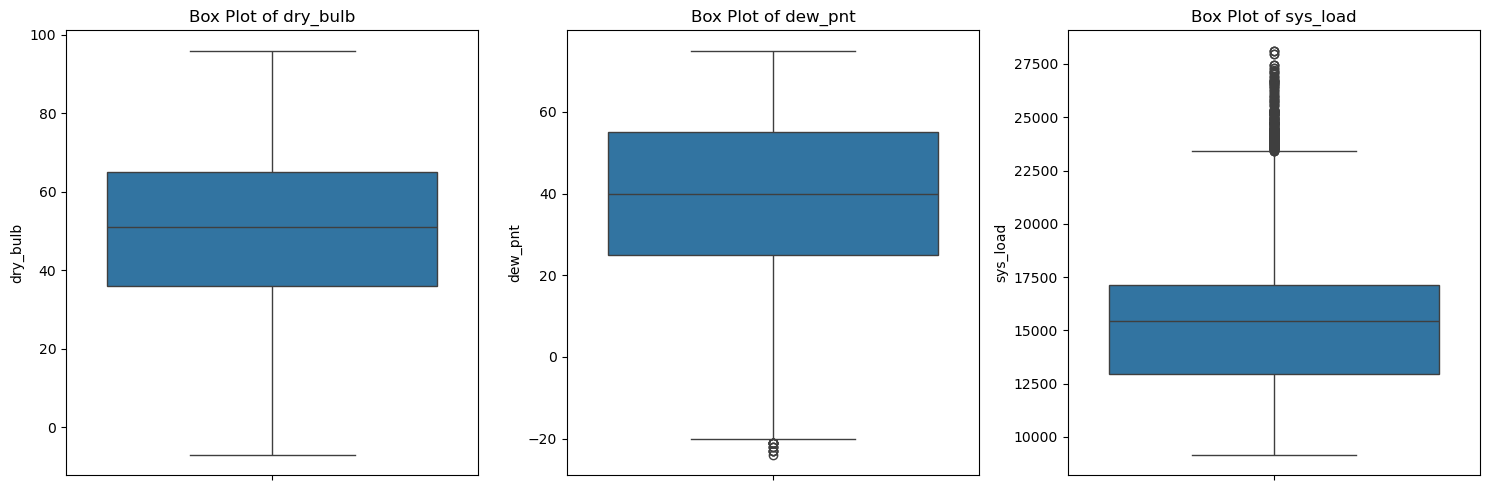

In [17]:
# Columns to check for outliers
outlier_cols = ['dry_bulb', 'dew_pnt', 'sys_load']

plt.figure(figsize=(15, 5))
for i, col in enumerate(outlier_cols):
    plt.subplot(1, len(outlier_cols), i + 1)
    sns.boxplot(y=data[col])
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)
plt.tight_layout()
plt.show()


In [18]:
# Quantifying Outliers using the IQR Method
outlier_cols = ['dry_bulb', 'dew_pnt', 'sys_load']

for col in outlier_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    print(f"\nOutliers in '{col}':")
    print(f"  - Lower Bound: {lower_bound:.2f}")
    print(f"  - Upper Bound: {upper_bound:.2f}")
    print(f"  - Number of outliers: {len(outliers)}")
    if len(outliers) > 0:
        print(f"  - Percentage of outliers: {(len(outliers) / len(data)) * 100:.2f}%")
    else:
        print("  - No outliers found by IQR method.")

#Outlier Handling: The outliers in dew_pnt and sys_load are within acceptable range, so they remain in the dataset without any changes.


Outliers in 'dry_bulb':
  - Lower Bound: -7.50
  - Upper Bound: 108.50
  - Number of outliers: 0
  - No outliers found by IQR method.

Outliers in 'dew_pnt':
  - Lower Bound: -20.00
  - Upper Bound: 100.00
  - Number of outliers: 16
  - Percentage of outliers: 0.06%

Outliers in 'sys_load':
  - Lower Bound: 6664.12
  - Upper Bound: 23405.12
  - Number of outliers: 243
  - Percentage of outliers: 0.92%


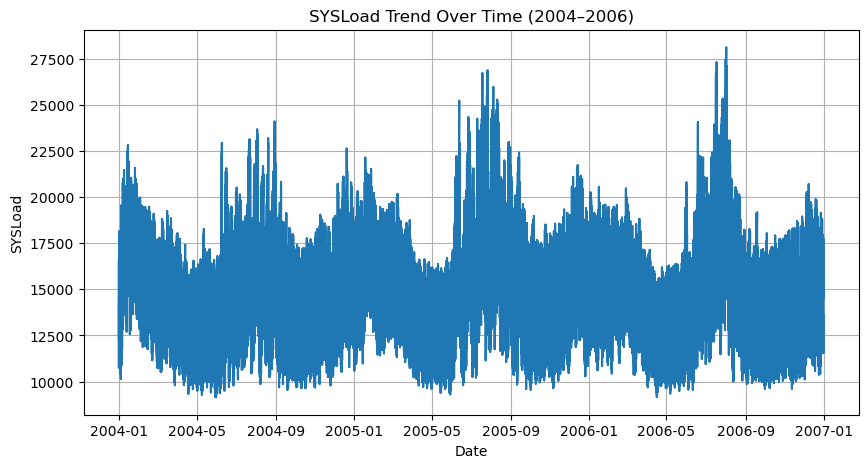

In [19]:
#STEP 2: EXPLORATORY DATA ANALYSIS
#Use only training period for EDA: 2004-01-01 to 2006-12-31
eda_data = data[(data['date'] >= '2004-01-01') & (data['date'] < '2007-01-01')].copy()
eda_data = eda_data.sort_values('date')

#SYSLoad trend over time
plt.figure(figsize=(10, 5))
plt.plot(eda_data['date'], eda_data['sys_load'])
plt.title("SYSLoad Trend Over Time (2004–2006)")
plt.xlabel("Date")
plt.ylabel("SYSLoad")
plt.grid(True)
plt.show()

In [20]:
#Inference:Electricity demand follows a repeating yearly pattern.
#It rises during very hot or very cold months and drops during milder seasons.
#This shows that demand is strongly influenced by weather changes throughout the year.

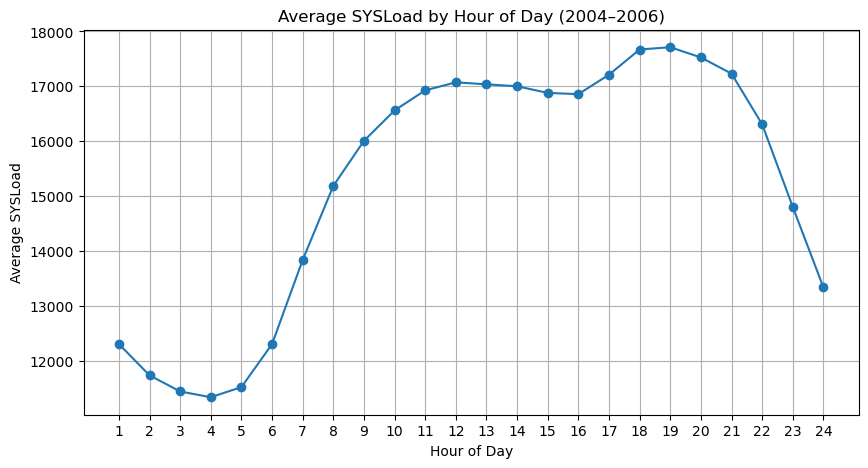

In [21]:
#Average SYSLoad by hour of day
hourly_avg = eda_data.groupby('hour', as_index=False)['sys_load'].mean()

plt.figure(figsize=(10, 5))
plt.plot(hourly_avg['hour'], hourly_avg['sys_load'], marker='o')
plt.title("Average SYSLoad by Hour of Day (2004–2006)")
plt.xlabel("Hour of Day")
plt.ylabel("Average SYSLoad")
plt.xticks(range(1, 25))
plt.grid(True)
plt.show()



In [22]:
#Inference:Electricity use is lowest during late night and early morning.
#It starts increasing after sunrise, stays high throughout the day, and peaks in the evening when people return home.
#This confirms a clear daily usage cycle.

<Figure size 1000x500 with 0 Axes>

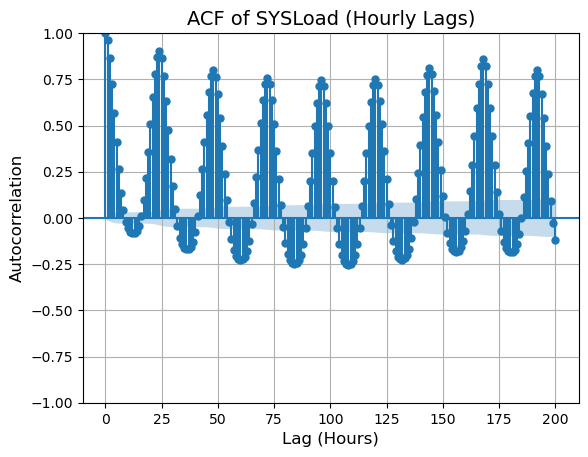

<Figure size 1200x500 with 0 Axes>

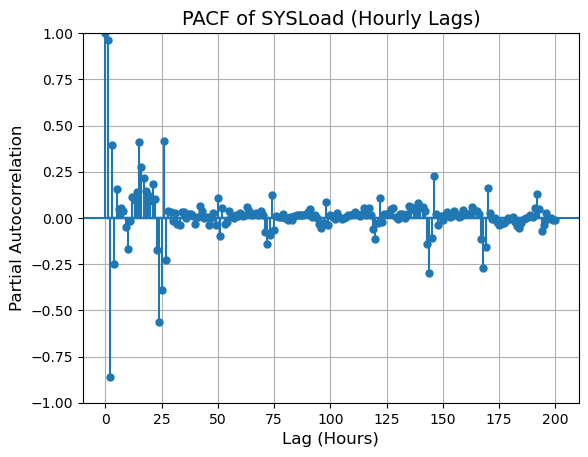

In [23]:
#Autocorrelation & Partial Autocorrelation (ACF/PACF) Analysis

# Convert and sort
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by=['date', 'hour']).reset_index(drop=True)

# ACF Plot
plt.figure(figsize=(10, 5))
plot_acf(data['sys_load'], lags=200)
plt.xlabel("Lag (Hours)", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)
plt.title("ACF of SYSLoad (Hourly Lags)", fontsize=14)
plt.grid(True)
plt.show()

# PACF Plot
plt.figure(figsize=(12, 5))
plot_pacf(data['sys_load'], lags=200, method='ywm')
plt.xlabel("Lag (Hours)", fontsize=12)
plt.ylabel("Partial Autocorrelation", fontsize=12)
plt.title("PACF of SYSLoad (Hourly Lags)", fontsize=14)
plt.grid(True)
plt.show()

In [24]:
#Inference:
#The ACF/PACF plots show strong repeating spikes at 24-hour intervals, confirming a very stable daily seasonality
#where load at an hour is closely tied to the same hour on the previous day.
#The PACF also highlights short-term persistence, meaning both the previous hour and previous day's same hour strongly influence current load.

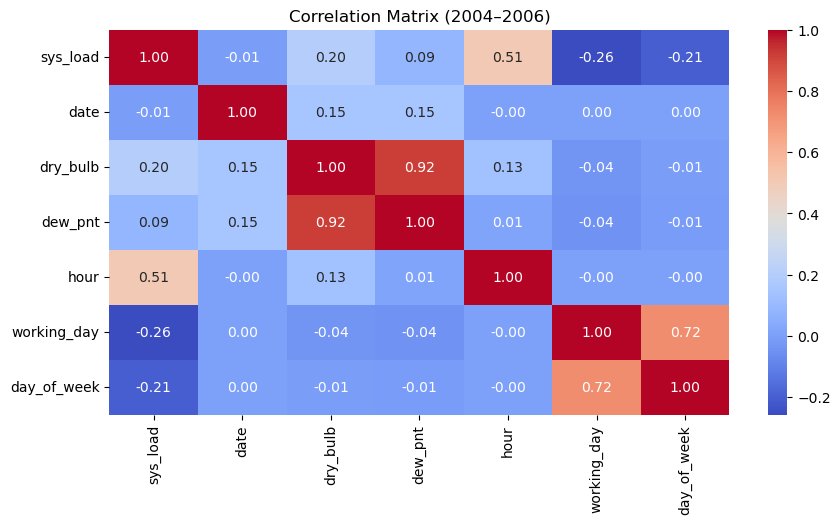

In [25]:
# Correlation matrix
corr_cols = ['sys_load','date','dry_bulb', 'dew_pnt', 'hour', 'working_day','day_of_week']
corr_matrix = eda_data[corr_cols].corr()

plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (2004–2006)")
plt.show()



In [26]:
#Inference: hour has the highest correlation and date has the lowest correlation with sys_load. day_of_weak, working_day and dry_bulb have
#decent correlation while dew_pnt has low correlation with sys_load. dry_bulb and dew_pnt are higly correlated with each other. In the same
#way, day_of_week and working_day are also higly correlated with each other

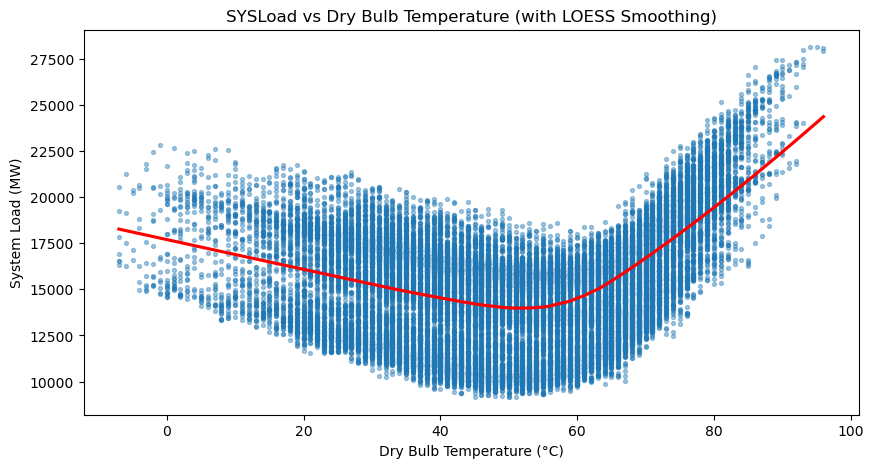

In [27]:
#Temperature–Load Relationship (LOESS Smoothed Curve)
plt.figure(figsize=(10, 5))
sns.regplot(
    x='dry_bulb',
    y='sys_load',
    data=data,
    lowess=True,
    scatter_kws={'s': 8, 'alpha': 0.4},
    line_kws={'color': 'red'}
)
plt.title("SYSLoad vs Dry Bulb Temperature (with LOESS Smoothing)")
plt.xlabel("Dry Bulb Temperature (°C)")
plt.ylabel("System Load (MW)")
plt.show()

In [28]:
#Inference:
#The LOESS temperature–load curve reveals a clear U-shaped pattern, indicating that electricity demand increases during very cold and very hot conditions due to heating and cooling needs,
#while moderate temperatures correspond to lower load. This confirms that temperature affects load in a nonlinear way and must be modeled accordingly.

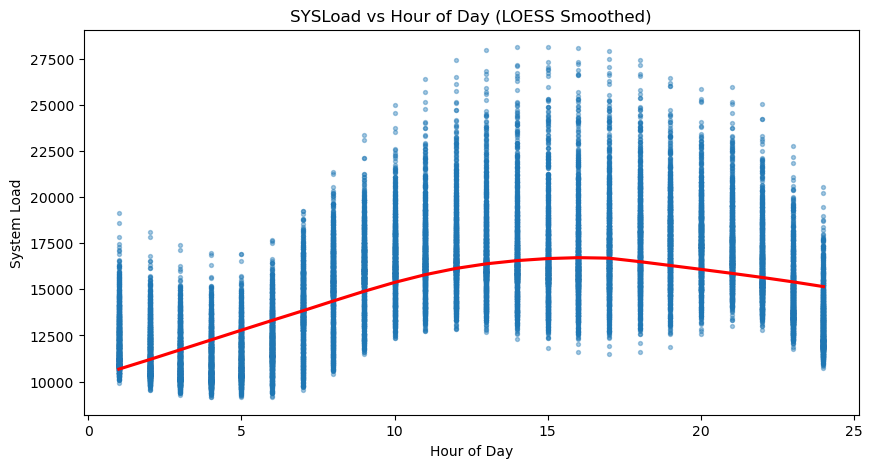

In [29]:
#SYSLoad vs Hour (LOESS Curve)
loess_data = eda_data.copy()
plt.figure(figsize=(10, 5))
sns.regplot(
    x='hour',
    y='sys_load',
    data=loess_data,
    lowess=True,
    scatter_kws={'s': 8, 'alpha': 0.4},
    line_kws={'color': 'red'}
)
plt.title("SYSLoad vs Hour of Day (LOESS Smoothed)")
plt.xlabel("Hour of Day")
plt.ylabel("System Load")
plt.show()


In [30]:
#Inference: Electricity demand rises steadily from early morning, stays high during the afternoon and early evening, and then drops again at night.
#This confirms a clear daily usage cycle, people use more electricity during daytime and evening hours.

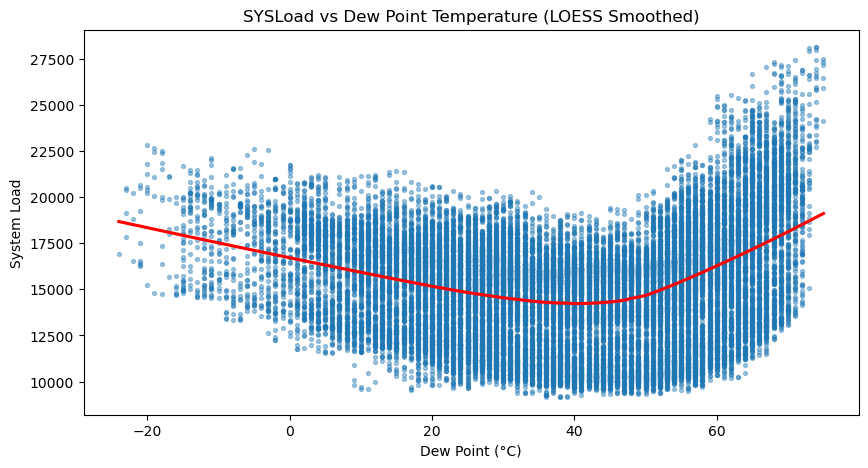

In [31]:
#SYSLoad vs Dew Point Temperature (LOESS Curve)
plt.figure(figsize=(10, 5))
sns.regplot(
    x='dew_pnt',
    y='sys_load',
    data=loess_data,
    lowess=True,
    scatter_kws={'s': 8, 'alpha': 0.4},
    line_kws={'color': 'red'}
)
plt.title("SYSLoad vs Dew Point Temperature (LOESS Smoothed)")
plt.xlabel("Dew Point (°C)")
plt.ylabel("System Load")
plt.show()


In [32]:
#Inference:Demand is lowest at moderate dew point levels. It increases during very low and very high dew points.
#This means electricity usage goes up during both extremely dry and extremely humid conditions, usually because heating or cooling systems run more during these times.

C:\Anaconda\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


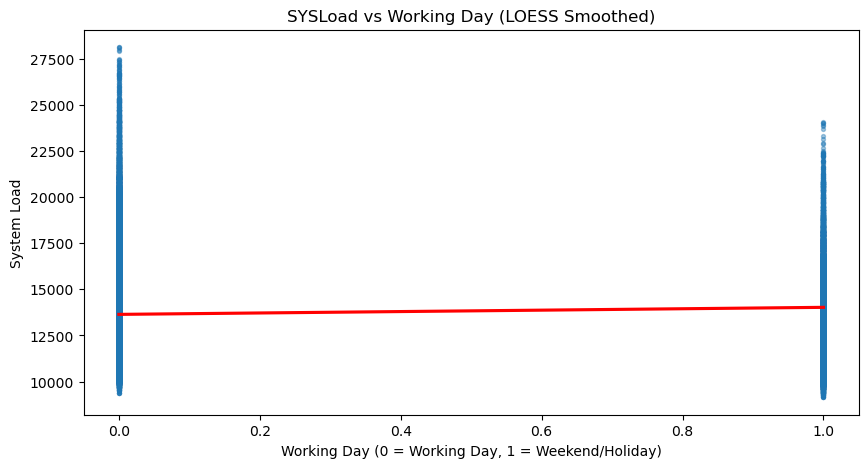

In [33]:
#SYSLoad vs Working Day (LOESS Curve)
plt.figure(figsize=(10, 5))
sns.regplot(
    x='working_day',
    y='sys_load',
    data=loess_data,
    lowess=True,
    scatter_kws={'s': 8, 'alpha': 0.4},
    line_kws={'color': 'red'}
)
plt.title("SYSLoad vs Working Day (LOESS Smoothed)")
plt.xlabel("Working Day (0 = Working Day, 1 = Weekend/Holiday)")
plt.ylabel("System Load")
plt.show()


In [34]:
#Inference: The trend is nearly flat, which means electricity usage does not change much between working days and weekends/holidays.
#The overall demand stays fairly similar regardless of the type of day.

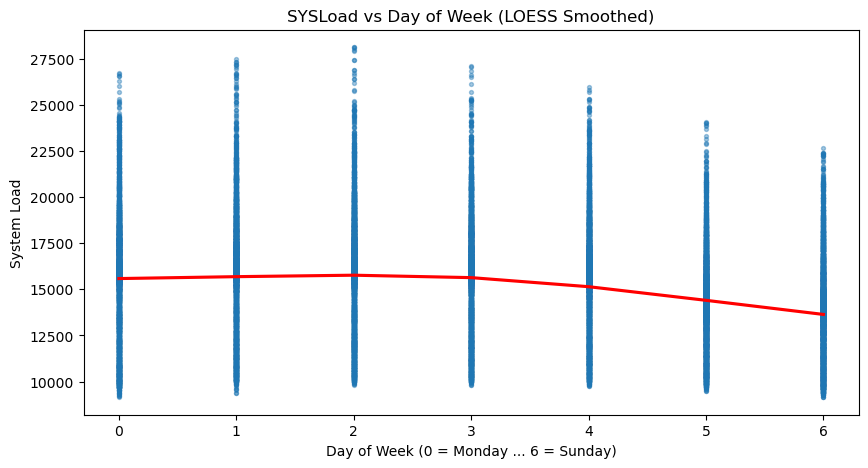

In [35]:
#SYSLoad vs Day of Week (LOESS Curve)
plt.figure(figsize=(10, 5))
sns.regplot(
    x='day_of_week',
    y='sys_load',
    data=loess_data,
    lowess=True,
    scatter_kws={'s': 8, 'alpha': 0.4},
    line_kws={'color': 'red'}
)
plt.title("SYSLoad vs Day of Week (LOESS Smoothed)")
plt.xlabel("Day of Week (0 = Monday ... 6 = Sunday)")
plt.ylabel("System Load")
plt.show()


In [36]:
#Inference:Load is slightly higher on weekdays and dips a bit toward the weekend, but the change is small.
#This suggests electricity demand stays fairly consistent across the week with only a mild weekend effect.

In [37]:
#STEP 3: DATA PREPARATION AND CLEANING FOR TEST DATA FILE
# Loading data & showing all test data
tdata=pd.read_excel('test_data.xlsx')
print(tdata)

          Date  Hour  DryBulb  DewPnt  SYSLoad  NumDate
0   2007-01-01     1       31      23      NaN   733000
1   2007-01-01     2       32      25      NaN   733000
2   2007-01-01     3       32      26      NaN   733000
3   2007-01-01     4       33      27      NaN   733000
4   2007-01-01     5       33      29      NaN   733000
..         ...   ...      ...     ...      ...      ...
739 2007-01-31    20       25       7      NaN   733000
740 2007-01-31    21       24       7      NaN   733000
741 2007-01-31    22       24       8      NaN   733000
742 2007-01-31    23       23       8      NaN   733000
743 2007-01-31    24       22       8      NaN   733000

[744 rows x 6 columns]


In [38]:
# Create a new column working_day
tdata['Date'] = pd.to_datetime(tdata['Date'])
isworkday = np.isin(tdata.Date.dt.weekday, [0, 1, 2, 3, 4]) & ~np.isin(tdata['Date'], holidays)
tdata['working_day'] = np.where(isworkday,0,1)
# Create a new column day_of_week (Monday=0, Sunday=6)
tdata['day_of_week'] = tdata['Date'].dt.weekday.astype('Int64')
print("First 5 rows of tdata with 'Date' and 'working_day' columns:")
display(tdata.head())

First 5 rows of tdata with 'Date' and 'working_day' columns:


,Date,Hour,DryBulb,DewPnt,SYSLoad,NumDate,working_day,day_of_week
0,2007-01-01,1,31,23,NaN,733000,1,0
1,2007-01-01,2,32,25,NaN,733000,1,0
2,2007-01-01,3,32,26,NaN,733000,1,0
3,2007-01-01,4,33,27,NaN,733000,1,0
4,2007-01-01,5,33,29,NaN,733000,1,0


In [39]:
#Display dimensions of data frame
tdata.shape

(744, 8)

In [40]:
# Checking for data types
tdata.dtypes

Date           datetime64[ns]
Hour                    int64
DryBulb                 int64
DewPnt                  int64
SYSLoad               float64
NumDate                 int64
working_day             int64
day_of_week             Int64
dtype: object

In [41]:
#Changing all column names to lowercase
tdata.columns = tdata.columns.str.lower()

#rename column names
tdata.rename(columns={'drybulb': 'dry_bulb', 'dewpnt': 'dew_pnt', 'numdate': 'num_date', 'sysload':'sys_load'}, inplace=True)

print("Column names after changes:")
print(tdata.columns)

Column names after changes:
Index(['date', 'hour', 'dry_bulb', 'dew_pnt', 'sys_load', 'num_date',
       'working_day', 'day_of_week'],
      dtype='object')


In [42]:
#Drop num_date column since we already have date column
tdata.drop('num_date', axis=1, inplace=True)
print("Columns after dropping 'num_date':")
print(tdata.columns)

Columns after dropping 'num_date':
Index(['date', 'hour', 'dry_bulb', 'dew_pnt', 'sys_load', 'working_day',
       'day_of_week'],
      dtype='object')


In [43]:
# Checking for duplicate rows
print("\nDuplicate rows found:")
tdata.duplicated().sum()


Duplicate rows found:


np.int64(0)

In [44]:
# Checking for missing values in each column
tdata.isnull().sum()

#Note: sys_load null values will be predicted using predictive models

date             0
hour             0
dry_bulb         0
dew_pnt          0
sys_load       744
working_day      0
day_of_week      0
dtype: int64

In [45]:
#Summary statistics to check if data is within valid and acceptable range
tdata.describe()

,date,hour,dry_bulb,dew_pnt,sys_load,working_day,day_of_week
count,744,744.000000,744.000000,744.000000,0.0,744.000000,744.0
mean,2007-01-16 00:00:00,12.500000,30.540323,18.630376,NaN,0.322581,2.806452
min,2007-01-01 00:00:00,1.000000,1.000000,-13.000000,NaN,0.000000,0.0
25%,2007-01-08 00:00:00,6.750000,21.000000,7.000000,NaN,0.000000,1.0
50%,2007-01-16 00:00:00,12.500000,31.000000,18.000000,NaN,0.000000,3.0
75%,2007-01-24 00:00:00,18.250000,40.000000,30.000000,NaN,1.000000,5.0
max,2007-01-31 00:00:00,24.000000,66.000000,59.000000,NaN,1.000000,6.0
std,NaN,6.926843,12.622311,15.461381,NaN,0.467778,2.008102


In [46]:
#STEP 4: TIME SERIES FORECASTING
#Model 1:Random Forest
#Convert day_of_week into categorical variable
data['day_of_week'] = data['day_of_week'].astype('category')

#Create dummy variables for day_of_week variable
data = pd.get_dummies(data, columns=['day_of_week'], drop_first=True)
print(data.head())

#Define predictors and drop date + target
predictors = ['hour', 'dry_bulb', 'dew_pnt', 'working_day', 'day_of_week_1','day_of_week_2','day_of_week_3','day_of_week_4','day_of_week_5','day_of_week_6',]
target = 'sys_load'

        date  hour  dry_bulb  dew_pnt  sys_load  working_day  day_of_week_1  \
0 2004-01-01   1.0      37.0     25.0   12230.0            1          False   
1 2004-01-01   2.0      37.0     25.0   11534.0            1          False   
2 2004-01-01   3.0      39.0     24.0   11038.0            1          False   
3 2004-01-01   4.0      38.0     22.0   10777.0            1          False   
4 2004-01-01   5.0      37.0     20.0   10764.0            1          False   

   day_of_week_2  day_of_week_3  day_of_week_4  day_of_week_5  day_of_week_6  
0          False           True          False          False          False  
1          False           True          False          False          False  
2          False           True          False          False          False  
3          False           True          False          False          False  
4          False           True          False          False          False  


In [47]:
#Split into X and y
X = data[predictors]
y = data[target]

In [48]:
#Chronological train–valid split
split_idx = int(len(data) * 0.8)

X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]

X_valid = X.iloc[split_idx:]
y_valid = y.iloc[split_idx:]

In [49]:
# Define the best parameters for the Random Forest model
best_params = {
    "n_estimators": 150,
    "max_depth": 10,
    "min_samples_split": 8,
    "min_samples_leaf": 2,
    "max_features": 'sqrt'
}

In [50]:
# Initialize Random Forest Regressor with reasonable params
rf = RandomForestRegressor(**best_params,random_state=42)

In [51]:
# RFECV: Recursive feature elimination with cross-validation for variable selection
rfecv = RFECV(
    estimator=rf,
    step=1,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

In [52]:
# Fit RFECV on training data
rfecv.fit(X_train, y_train)

RFECV(cv=5,
      estimator=RandomForestRegressor(max_depth=10, max_features='sqrt',
                                      min_samples_leaf=2, min_samples_split=8,
                                      n_estimators=150, random_state=42),
      n_jobs=-1, scoring='neg_mean_squared_error')

In [53]:
# Get the variables selected through RFECV
selected_features = X_train.columns[rfecv.support_]
print("Optimal number of features:", rfecv.n_features_)
print("Selected features:", list(selected_features))

Optimal number of features: 4
Selected features: ['hour', 'dry_bulb', 'dew_pnt', 'working_day']


### Define best parametrs

In [54]:
# 1. Define the parameter grid
param_dist = {
    'n_estimators': [100, 150, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 8, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

In [55]:
# 2. Initialize the model
rf_tuner = RandomForestRegressor(random_state=42)

In [56]:
# 3. Setup RandomizedSearchCV
# n_iter=10 means it will try 10 random combinations
random_search = RandomizedSearchCV(
    estimator=rf_tuner, 
    param_distributions=param_dist, 
    n_iter=10, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    random_state=42
)

In [57]:
# 4. Fit on the SELECTED features from your RFECV step
random_search.fit(X_train[selected_features], y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 8, 10],
                                        'n_estimators': [100, 150, 200, 300]},
                   random_state=42, scoring='neg_mean_squared_error')

In [58]:
best_params_final = random_search.best_params_
print("Best Parameters Found:", best_params_final)

Best Parameters Found: {'n_estimators': 200, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 20}


In [59]:
# FINAL MODEL TRAINING ---
# Create the final model using the best params and best features
rf_final = RandomForestRegressor(**best_params_final, random_state=42)


In [60]:
#Train final model on "selected_features"
rf_final.fit(X_train[selected_features], y_train)

RandomForestRegressor(max_depth=20, max_features='log2', min_samples_leaf=4,
                      min_samples_split=8, n_estimators=200, random_state=42)

In [61]:
# 5. Get results
print("Best Parameters:", random_search.best_params_)
best_rf = random_search.best_estimator_

Best Parameters: {'n_estimators': 200, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 20}


In [62]:
# Create importance dataframe using the OPTIMIZED model
feature_importance = pd.DataFrame({
    "Feature": selected_features,
    "Importance": random_search.best_estimator_.feature_importances_
})

# Sort by most important at the top
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# View the results
print(feature_importance)

       Feature  Importance
0         hour    0.552072
1     dry_bulb    0.267480
2      dew_pnt    0.106185
3  working_day    0.074263


In [63]:
#Training Data: Predicting using "selected_features"
y_pred = rf_final.predict(X_train[selected_features])

result = pd.DataFrame({'Predicted': y_pred,'Actual': y_train,'Residual': y_train - y_pred})

In [64]:
#Validation Data: Predicting using "selected_features"
y_pred_valid = rf_final.predict(X_valid[selected_features])
r2_valid = r2_score(y_valid, y_pred_valid)

# Calculate Root Mean Squared Error (RMSE)
# Note: mean_squared_error returns MSE, so we take the square root (np.sqrt)
rmse_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid))

# Display only the required metrics, formatted to 4 decimal places
print(f"Validation Root Mean Squared Error (RMSE): {rmse_valid:.4f}")
print(f"Validation R-squared (R2): {r2_valid:.4f}")

# The DataFrame creation using the validation results
result_valid = pd.DataFrame({'Predicted': y_pred_valid, 'Actual': y_valid, 'Residual': y_valid - y_pred_valid})

Validation Root Mean Squared Error (RMSE): 719.2422
Validation R-squared (R2): 0.9526


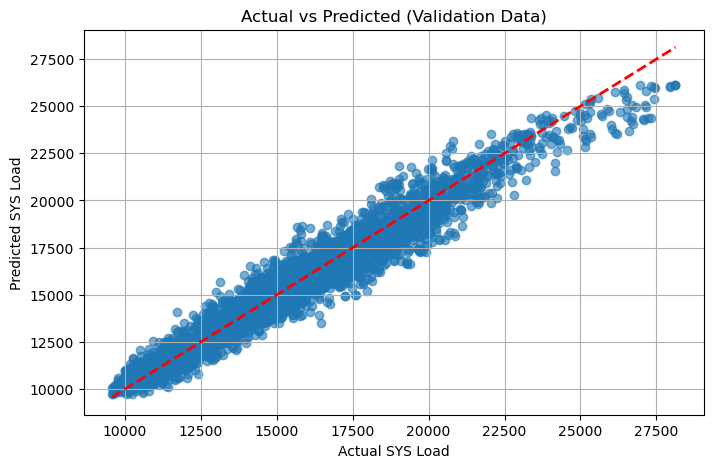

In [65]:
# Actual vs Predicted Plot for validation data
plt.figure(figsize=(8,5))
plt.scatter(y_valid, y_pred_valid, alpha=0.6)
plt.xlabel("Actual SYS Load")
plt.ylabel("Predicted SYS Load")
plt.title("Actual vs Predicted (Validation Data)")
plt.plot([y_valid.min(), y_valid.max()],
         [y_valid.min(), y_valid.max()],
         'r--', linewidth=2)
plt.grid(True)
plt.show()

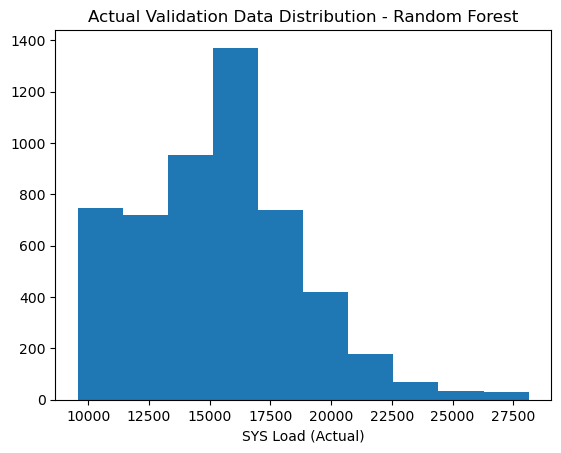

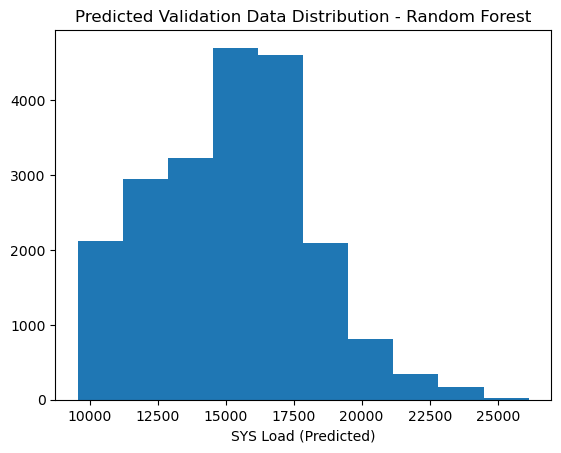

In [66]:
y_valid_series = pd.Series(y_valid, name="Actual")
y_pred_series = pd.Series(y_pred, name="Predicted")

fig, ax = plt.subplots()
y_valid_series.hist(ax=ax) # Using the unscaled actual series
ax.set_xlabel('SYS Load (Actual)')
plt.title("Actual Validation Data Distribution - Random Forest")
plt.grid(False)
plt.show()

# Predicted Validation Data Distribution
fig, ax = plt.subplots()
y_pred_series.hist(ax=ax) # Using the unscaled predicted series
ax.set_xlabel('SYS Load (Predicted)')
plt.title("Predicted Validation Data Distribution - Random Forest")
plt.grid(False)
plt.show()

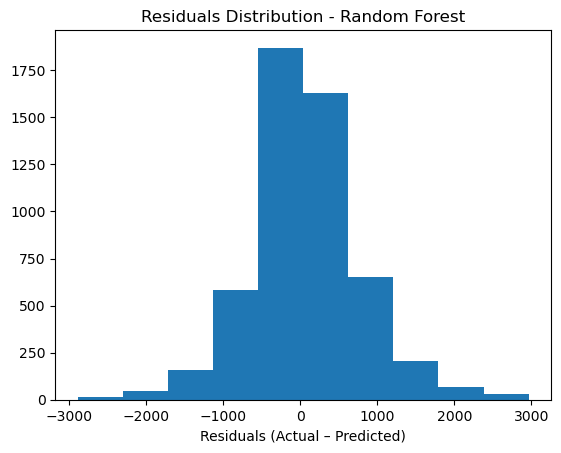

In [67]:
# Residuals Distribution for validation data
residuals = y_valid - y_pred_valid

fig, ax = plt.subplots()
residuals.hist(ax=ax)
ax.set_xlabel('Residuals (Actual – Predicted)')
plt.title("Residuals Distribution - Random Forest")
plt.grid(False)
plt.show()

In [68]:
#Inference about Model performance
# The Random Forest model performance is strong. The model has achieved a RMSE of 719.2422 and R² of 0.9526 on validation data, indicating that the
# predictions are very close to the actual sys_load values. The high R² shows that the model captures majority of the variance in sys_load.
# The low RMSE implies that the model's error magnitude is low and well within the acceptable range. These values confirms high predictive
# accuracy of the Random Forest model. It confirms that the model is well-trained and effective for forecasting sys_load for the future.

In [69]:
#Model 2:ANN

In [70]:
#Define predictors and drop date + target
predictors = ['hour', 'dry_bulb', 'dew_pnt', 'working_day', 'day_of_week_1','day_of_week_2','day_of_week_3','day_of_week_4','day_of_week_5','day_of_week_6',]
target = 'sys_load'

In [71]:
#Split into X and y
X = data[predictors]
y = data[target]

In [72]:
#Chronological train–valid split
split_idx = int(len(data) * 0.8)

X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]

X_valid = X.iloc[split_idx:]
y_valid = y.iloc[split_idx:]

In [73]:
#Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_valid_scaled = scaler_X.transform(X_valid)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).ravel()

In [ ]:
#Train ANN
ann = MLPRegressor(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    alpha=0.0001,
    max_iter=2000,
    batch_size=64,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

ann.fit(X_train_scaled, y_train_scaled)

In [ ]:
#Predict on validation (scaled + actual)
y_pred_scaled = ann.predict(X_valid_scaled)

# reverse scaling
y_valid_actual = y_valid
y_pred_actual  = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()

In [ ]:
#Evaluate model performance on validation data
mse = mean_squared_error(y_valid_actual, y_pred_actual)
rmse = mse ** 0.5

r2 = r2_score(y_valid_actual, y_pred_actual)

print("Validation RMSE:", rmse)
print("Validation R²:", r2)



In [ ]:
# Actual vs Predicted Plot for validation data
plt.figure(figsize=(8,5))
plt.scatter(y_valid_actual, y_pred_actual, alpha=0.6)
plt.xlabel("Actual SYS Load")
plt.ylabel("Predicted SYS Load")
plt.title("Actual vs Predicted (Validation Data)")
plt.plot([y_valid_actual.min(), y_valid_actual.max()],
         [y_valid_actual.min(), y_valid_actual.max()],
         'r--', linewidth=2)
plt.grid(True)
plt.show()

In [ ]:
# Convert numpy arrays to pandas Series
y_valid_actual_series = pd.Series(y_valid_actual, name="Actual")
y_pred_actual_series = pd.Series(y_pred_actual, name="Predicted")

# Actual Validation Data Distribution
fig, ax = plt.subplots()
y_valid_actual_series.hist(ax=ax)
ax.set_xlabel('SYS Load (Actual)')
plt.title("Actual Validation Data Distribution - ANN")
plt.grid(False)
plt.show()

# Predicted Validation Data Distribution
fig, ax = plt.subplots()
y_pred_actual_series.hist(ax=ax)
ax.set_xlabel('SYS Load (Predicted)')
plt.title("Predicted Validation Data Distribution - ANN")
plt.grid(False)
plt.show()

In [ ]:
# Residuals Distribution for validation data
residuals = y_valid_actual - y_pred_actual

fig, ax = plt.subplots()
residuals.hist(ax=ax)
ax.set_xlabel('Residuals (Actual – Predicted)')
plt.title("Residuals Distribution - ANN")
plt.grid(False)
plt.show()


In [ ]:
#Inference about Model performance
# The ANN model performance is strong. The model has achieved a RMSE of 661.589 and R² of 0.960 on validation data, indicating that the
# predictions are very close to the actual sys_load values. The high R² shows that the model captures majority of the variance in sys_load.
# The low RMSE implies that the model's error magnitude is low and well within the acceptable range. These values confirms high predictive
# accuracy of the ANN model. It confirms that the model is well-trained and effective for forecasting sys_load for the future.

In [ ]:
print(tdata.columns)

In [ ]:
#Convert day_of_week into categorical variable
tdata['day_of_week'] = tdata['day_of_week'].astype('category')

#Create dummy variables for day_of_week variable
tdata = pd.get_dummies(tdata, columns=['day_of_week'], drop_first=True)

#Train the best model(out of the two models developed) on the full dataset for final test data prediction
X_full = data[predictors]
y_full = data[target]

X_full_scaled = scaler_X.fit_transform(X_full)
y_full_scaled = scaler_y.fit_transform(y_full.values.reshape(-1,1)).ravel()

ann_final = MLPRegressor(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    alpha=0.0001,
    max_iter=2000,
    batch_size=64,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

ann_final.fit(X_full_scaled, y_full_scaled)

In [ ]:
#Remove sys_load column since it is the target variable
tdata.drop('sys_load', axis=1, inplace=True, errors='ignore')

# Define predictors
X_test = tdata[predictors]

# scale test predictors
X_test_scaled = scaler_X.transform(X_test)

# predict
tdata_pred_scaled = ann_final.predict(X_test_scaled)

# inverse transform prediction
tdata['sys_load_pred'] = scaler_y.inverse_transform(tdata_pred_scaled.reshape(-1,1)).ravel()

# Display test dataset
print(tdata.head())

# Convert test dataset to csv
tdata.to_csv('pred_jan2007.csv', index=False)

In [ ]:
# Distribution of sys_load_pred
plt.figure
plt.hist(tdata['sys_load_pred'], bins=30, edgecolor='k')
plt.xlabel('sys_load Predictions')
plt.ylabel('Frequency')
plt.title('Distribution of sys_load Predictions for Jan 2007')

In [ ]:
tdata.columns

In [ ]:
# 1. Convert to datetime using the existing 'date' column
tdata['Date'] = pd.to_datetime(tdata.date, format='%Y-%m-%d')

# 2. Group by Date and take the mean of the predictions 
# This removes the 24-point "stack" and creates one point per day
daily_predictions = tdata.groupby('Date')['sys_load_pred'].mean()

# 3. Create the Series using the aggregated data
tdata_pred = pd.Series(daily_predictions.values, index=daily_predictions.index, name='sys_load_pred')

# 4. Plot the Series
# Because there is now only one Y value for every X value, the vertical lines disappear.
tdata_pred.plot(figsize=(12, 6), title='Daily Average sys_load Predictions')
plt.xlabel('Date')
plt.ylabel('sys_load Predictions')
plt.title('Time Series of sys_load Predictions for Jan 2007')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
#Project Conclusion
#In conclusion, The ANN model achieves a validation RMSE of 676.20 and an R² of 0.96, indicating strong predictive ability and good
#capture of nonlinear relationships in system load than Random Forest Model. The Random Forest model performs slightly weaker in comparison, with
#a comparatively higher RMSE of 766.20 and a lower R² of 0.95 (RMSE of 719.2422 and R² of 0.9526 ), meaning its predictions deviate more from the actual values. Although both models
#perform well, the ANN model clearly delivers lower prediction error and better overall fit, making it the superior choice for forecasting
#system load.Therefore, the ANN model is selected as the final predictive model for generating forecasts for Jan 2007 (test data).